In [83]:
import math
import numpy as np
import pandas as pd 
import scipy.stats as stats 
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from scipy.stats import pearsonr

from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [84]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


#  Hierarchical clustering(a caso)

In [41]:
df=pd.read_csv("../dataset-progetto/train.csv", skipinitialspace=True)

----------------------------------------------------------------------
## visualizzazione e selezione degli attributi da trasformare / eliminare

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   15000 non-null  object 
 1   duration_ms            15000 non-null  int64  
 2   explicit               15000 non-null  bool   
 3   popularity             15000 non-null  int64  
 4   artists                15000 non-null  object 
 5   album_name             15000 non-null  object 
 6   danceability           15000 non-null  float64
 7   energy                 15000 non-null  float64
 8   key                    15000 non-null  int64  
 9   loudness               15000 non-null  float64
 10  mode                   10550 non-null  float64
 11  speechiness            15000 non-null  float64
 12  acousticness           15000 non-null  float64
 13  instrumentalness       15000 non-null  float64
 14  liveness               15000 non-null  float64
 15  va

In [43]:
df.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

C:\Users\lollo\AppData\Local\Temp\ipykernel_18400\22157288.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)


,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing
duration_ms,1.000000,-0.048723,-0.076202,-0.080932,0.102996,0.016712,0.039403,-0.023310,-0.074774,-0.184902,0.079685,-0.021184,-0.141938,0.048765,0.999918,0.009033,0.839313,0.838041,-0.005830,-0.010400
explicit,-0.048723,1.000000,-0.013096,0.056992,0.124405,-0.000991,0.131777,-0.042846,0.294287,-0.113975,-0.125101,0.006995,0.008631,0.016972,-0.048699,0.051260,-0.039830,-0.039435,0.029119,-0.005878
popularity,-0.076202,-0.013096,1.000000,0.051046,-0.056547,-0.008992,0.046703,0.073043,-0.096382,0.078424,-0.266843,0.027105,0.077652,-0.024162,-0.076228,-0.003160,-0.084774,-0.089134,-0.003665,0.008733
danceability,-0.080932,0.056992,0.051046,1.000000,0.193940,0.035311,0.385244,-0.072422,0.111454,-0.199082,-0.202316,-0.174193,0.559578,0.092267,-0.080891,0.292167,-0.033604,-0.069332,0.011602,-0.026273
energy,0.102996,0.124405,-0.056547,0.193940,1.000000,0.057815,0.720907,-0.079969,0.143454,-0.699454,-0.203111,0.191024,0.284069,0.331538,0.102985,0.204646,0.243586,0.208615,0.040022,-0.037847
key,0.016712,-0.000991,-0.008992,0.035311,0.057815,1.000000,0.047718,-0.157515,0.018157,-0.049867,-0.001532,-0.007420,0.028221,0.022414,0.016786,0.028388,0.027133,0.022042,0.019790,-0.490366
loudness,0.039403,0.131777,0.046703,0.385244,0.720907,0.047718,1.000000,-0.033544,0.109793,-0.552519,-0.447106,0.047502,0.377743,0.308203,0.039415,0.250568,0.165565,0.131064,0.049174,-0.020563
mode,-0.023310,-0.042846,0.073043,-0.072422,-0.079969,-0.157515,-0.033544,1.000000,-0.064289,0.085246,-0.080035,0.015738,-0.006907,-0.013001,-0.023409,-0.019378,-0.030685,-0.027687,0.003698,0.261129
speechiness,-0.074774,0.294287,-0.096382,0.111454,0.143454,0.018157,0.109793,-0.064289,1.000000,-0.087997,-0.115803,0.050034,0.056068,0.062161,-0.074722,0.080739,-0.043217,-0.040820,0.026399,-0.022909
acousticness,-0.184902,-0.113975,0.078424,-0.199082,-0.699454,-0.049867,-0.552519,0.085246,-0.087997,1.000000,0.094256,-0.075924,-0.131961,-0.244244,-0.184846,-0.139706,-0.283324,-0.248164,-0.021155,0.022684


### time signature lo riempio con la moda

In [44]:
# Calcola la moda della colonna "time_signature"
mode_time_signature = df['time_signature'].mode().iloc[0]

# Rimpiazza i valori mancanti con la moda
df['time_signature'].fillna(mode_time_signature, inplace=True)

print('null presenti: ',df['time_signature'].isnull().sum())

null presenti:  0


### popularity confidence lo elimino x i troppi null

In [45]:
df = df.drop('popularity_confidence', axis=1)
df.head() #oki non c'è più

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,processing,genre
0,Long Road,241760,False,46,Funki Porcini,Hed Phone Sex,0.690,0.513,5,-12.529,...,0.53600,0.281,0.6350,142.221,241760,4.0,567.0,141.0,1.279305,j-dance
1,"Daniâl My Son, Where Did You Vanish?",444000,False,0,Siavash Amini,A Trail of Laughters,0.069,0.196,1,-24.801,...,0.93400,0.360,0.0336,75.596,444000,4.0,617.0,155.0,2.367412,iranian
2,Ondskapens Galakse,333506,False,3,Kvelertak,Nattesferd,0.363,0.854,2,-7.445,...,0.80000,0.262,0.4890,116.628,333507,4.0,652.0,162.0,3.700483,black-metal
3,Can't Look Away,269800,False,23,The Wood Brothers,One Drop of Truth,0.523,0.585,5,-5.607,...,0.00127,0.117,0.3850,140.880,269800,4.0,619.0,155.0,1.279305,bluegrass
4,Thunderground,307651,False,25,The Darkraver;DJ Vince,Happy Hardcore Top 100,0.643,0.687,7,-11.340,...,0.09690,0.299,0.6370,143.956,307652,4.0,733.0,183.0,4.067086,happy


### tolgo anche mode perchè non mi va 

In [46]:
df = df.drop('mode', axis=1)
df.head() #oki non c'è più

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,processing,genre
0,Long Road,241760,False,46,Funki Porcini,Hed Phone Sex,0.690,0.513,5,-12.529,...,0.53600,0.281,0.6350,142.221,241760,4.0,567.0,141.0,1.279305,j-dance
1,"Daniâl My Son, Where Did You Vanish?",444000,False,0,Siavash Amini,A Trail of Laughters,0.069,0.196,1,-24.801,...,0.93400,0.360,0.0336,75.596,444000,4.0,617.0,155.0,2.367412,iranian
2,Ondskapens Galakse,333506,False,3,Kvelertak,Nattesferd,0.363,0.854,2,-7.445,...,0.80000,0.262,0.4890,116.628,333507,4.0,652.0,162.0,3.700483,black-metal
3,Can't Look Away,269800,False,23,The Wood Brothers,One Drop of Truth,0.523,0.585,5,-5.607,...,0.00127,0.117,0.3850,140.880,269800,4.0,619.0,155.0,1.279305,bluegrass
4,Thunderground,307651,False,25,The Darkraver;DJ Vince,Happy Hardcore Top 100,0.643,0.687,7,-11.340,...,0.09690,0.299,0.6370,143.956,307652,4.0,733.0,183.0,4.067086,happy


### binarizzo explicit perchè è un booleano

In [47]:
df['explicit'] = df['explicit'].apply(lambda x: 1 if x else 0)

### tolgo features duration perchè troppo simile alla duration

In [48]:
df = df.drop('features_duration_ms' , axis = 1)

### correlazioni

In [49]:
df.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

C:\Users\lollo\AppData\Local\Temp\ipykernel_18400\22157288.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)


,duration_ms,explicit,popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,n_beats,n_bars,processing
duration_ms,1.000000,-0.048723,-0.076202,-0.080932,0.102996,0.016712,0.039403,-0.074774,-0.184902,0.079685,-0.021184,-0.141938,0.048765,0.008208,0.839313,0.838041,-0.010400
explicit,-0.048723,1.000000,-0.013096,0.056992,0.124405,-0.000991,0.131777,0.294287,-0.113975,-0.125101,0.006995,0.008631,0.016972,0.047941,-0.039830,-0.039435,-0.005878
popularity,-0.076202,-0.013096,1.000000,0.051046,-0.056547,-0.008992,0.046703,-0.096382,0.078424,-0.266843,0.027105,0.077652,-0.024162,-0.002659,-0.084774,-0.089134,0.008733
danceability,-0.080932,0.056992,0.051046,1.000000,0.193940,0.035311,0.385244,0.111454,-0.199082,-0.202316,-0.174193,0.559578,0.092267,0.274946,-0.033604,-0.069332,-0.026273
energy,0.102996,0.124405,-0.056547,0.193940,1.000000,0.057815,0.720907,0.143454,-0.699454,-0.203111,0.191024,0.284069,0.331538,0.191553,0.243586,0.208615,-0.037847
key,0.016712,-0.000991,-0.008992,0.035311,0.057815,1.000000,0.047718,0.018157,-0.049867,-0.001532,-0.007420,0.028221,0.022414,0.026923,0.027133,0.022042,-0.490366
loudness,0.039403,0.131777,0.046703,0.385244,0.720907,0.047718,1.000000,0.109793,-0.552519,-0.447106,0.047502,0.377743,0.308203,0.235546,0.165565,0.131064,-0.020563
speechiness,-0.074774,0.294287,-0.096382,0.111454,0.143454,0.018157,0.109793,1.000000,-0.087997,-0.115803,0.050034,0.056068,0.062161,0.075101,-0.043217,-0.040820,-0.022909
acousticness,-0.184902,-0.113975,0.078424,-0.199082,-0.699454,-0.049867,-0.552519,-0.087997,1.000000,0.094256,-0.075924,-0.131961,-0.244244,-0.131329,-0.283324,-0.248164,0.022684
instrumentalness,0.079685,-0.125101,-0.266843,-0.202316,-0.203111,-0.001532,-0.447106,-0.115803,0.094256,1.000000,-0.088589,-0.348955,-0.117466,-0.115587,0.034830,0.044498,-0.012960


----------------------------------------------
##  analizzo attributi categorici e i numerali

In [50]:
df.dtypes[df.dtypes.map(lambda x: x == 'int64')]

duration_ms    int64
explicit       int64
popularity     int64
key            int64
dtype: object

In [51]:
df.dtypes[df.dtypes.map(lambda x: x == 'float64')]

danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature      float64
n_beats             float64
n_bars              float64
processing          float64
dtype: object

In [52]:
df.dtypes[df.dtypes.map(lambda x: x == 'object')]

name          object
artists       object
album_name    object
genre         object
dtype: object

In [53]:
ueue = len(df.dtypes[df.dtypes.map(lambda x: x == 'float64')]) +len(df.dtypes[df.dtypes.map(lambda x: x == 'object')]) + len(df.dtypes[df.dtypes.map(lambda x: x == 'int64')]) 
print('tot attributi =', ueue)

tot attributi = 21


### tolgo i categorical

In [54]:
df_train = df.drop(['name', 'artists', 'album_name', 'genre'], axis=1)
df_train.head()

,duration_ms,explicit,popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,n_beats,n_bars,processing
0,241760,0,46,0.690,0.513,5,-12.529,0.0975,0.302000,0.53600,0.281,0.6350,142.221,4.0,567.0,141.0,1.279305
1,444000,0,0,0.069,0.196,1,-24.801,0.0805,0.283000,0.93400,0.360,0.0336,75.596,4.0,617.0,155.0,2.367412
2,333506,0,3,0.363,0.854,2,-7.445,0.0397,0.000089,0.80000,0.262,0.4890,116.628,4.0,652.0,162.0,3.700483
3,269800,0,23,0.523,0.585,5,-5.607,0.0765,0.066400,0.00127,0.117,0.3850,140.880,4.0,619.0,155.0,1.279305
4,307651,0,25,0.643,0.687,7,-11.340,0.0539,0.000576,0.09690,0.299,0.6370,143.956,4.0,733.0,183.0,4.067086


In [55]:
df_train = df_train.drop(['explicit','key','time_signature','processing','n_bars'], axis=1)
df_train.dtypes

duration_ms           int64
popularity            int64
danceability        float64
energy              float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
n_beats             float64
dtype: object

-------------------------------------------------------------------
## clustering

### hierarchical clustering

In [56]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [58]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(df_train)

In [59]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=10, n_clusters=None, affinity='euclidean', linkage='ward')
model = model.fit(train_data)

c:\Users\lollo\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


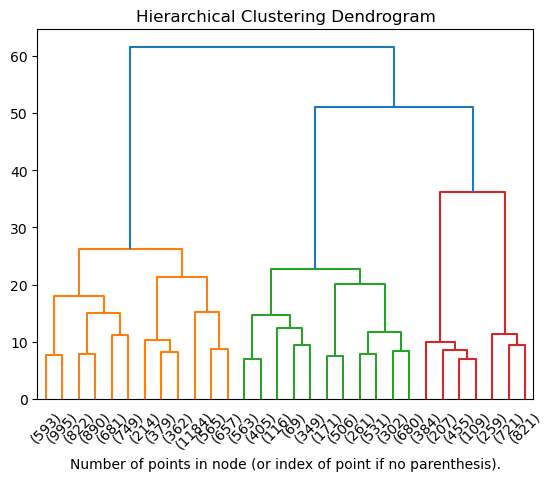

In [60]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [61]:
hier = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
hier.fit(train_data)

c:\Users\lollo\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', linkage='complete', n_clusters=4)

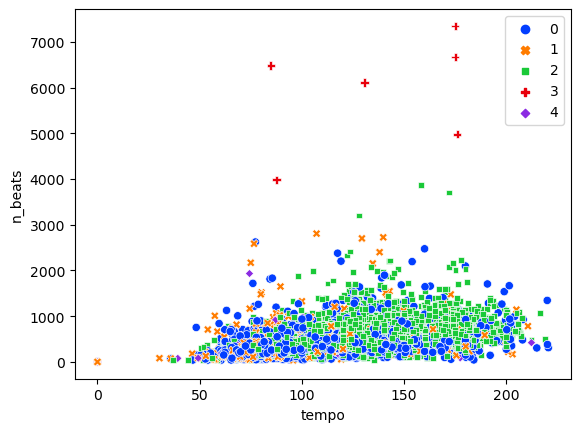

In [ ]:
sns.scatterplot(data=df_train, x="tempo", y="n_beats", hue=hier.labels_, 
                style=hier.labels_, palette="bright")
plt.show()

#### connectivity constraint (copiato prof non capisco cazzo faccia)

In [63]:
# hierarchical clustering
connectivity = kneighbors_graph(train_data, n_neighbors=100, include_self=False)

In [64]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=10, n_clusters=None, affinity='euclidean', 
                                linkage='ward', connectivity=connectivity)
model = model.fit(train_data)

c:\Users\lollo\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


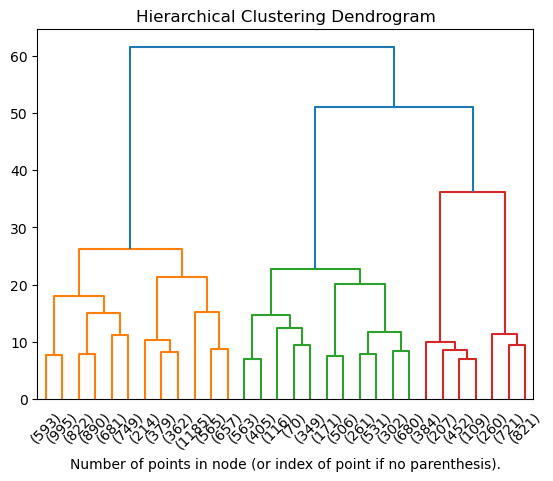

In [65]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


In [66]:
ward = AgglomerativeClustering(n_clusters=3, linkage='ward', affinity='euclidean',
                                   connectivity=connectivity)
ward.fit(train_data)

hist, bins = np.histogram(ward.labels_, bins=range(0, len(set(ward.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, ward.labels_))

c:\Users\lollo\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


labels {0: 2954, 1: 8092, 2: 3954}
silhouette 0.2513428609543069


In [67]:
print('complete linkage')
complete_linkage = AgglomerativeClustering(n_clusters=3, linkage='complete', affinity='l1',
                                              connectivity=connectivity)
complete_linkage.fit(train_data)
hist, bins = np.histogram(complete_linkage.labels_, 
                          bins=range(0, len(set(complete_linkage.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, complete_linkage.labels_))

complete linkage


c:\Users\lollo\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


labels {0: 14286, 1: 1, 2: 713}
silhouette 0.0018421571824488014


### K-means clustering (basato sulle Caratteristiche Audio)

#### definisco dataframe e binarizzo

In [338]:
df=pd.read_csv("../dataset-progetto/train.csv", skipinitialspace=True)

In [339]:
df_km = pd.read_csv("..\our_analyses\dataset_prepared.csv", skipinitialspace=True) # leggo dataframe gia pulito 

In [340]:
df_km['explicit'] = df_km['explicit'].apply(lambda x: 1 if x else 0) # binarizzo explicit

#### prendo solo gli attributi che mi interessano e li metto in un unico array:

creo un macro_genre che raggruppa i generi in 7 principali cosi sono di meno :3

In [341]:
# Definizione dei macro raggruppamenti
macro_genre = {
    'electronic ': ['techno', 'idm', 'industrial', 'chicago-house', 'breakbeat'],
    'metal': ['black-metal'],
    'pop': ['j-idol', 'mandopop', 'pop'],
    'classic': ['bluegrass'],
    'international': ['iranian', 'spanish', 'afrobeat', 'indian', 'brazil'],
    'relaxing': ['sleep', 'disney', 'study'],
    'other': ['happy', 'forro']
}


df = pd.DataFrame(df)
# Applicazione del raggruppamento
df['macro_genre'] = df['genre'].apply(lambda x: next((group for group, genres in macro_genre.items() if x in genres), 'other'))

# Visualizzazione del DataFrame risultante
print(df['macro_genre'])


0                other
1        international
2                metal
3              classic
4                other
             ...      
14995      electronic 
14996         relaxing
14997      electronic 
14998      electronic 
14999    international
Name: macro_genre, Length: 15000, dtype: object


In [342]:
df_km = df_km[['danceability','energy','acousticness','instrumentalness']]
X = df_km.values

# Rimuovi spazi bianchi extra dalle etichette delle classi
df['macro_genre'] = df['macro_genre'].str.strip()

# Stampare le etichette delle classi uniche dopo la pulizia
print(df['macro_genre'].unique())

y = np.array(df['macro_genre'])
y_map = {0:"electronic",1:"metal",2:"pop",3:"classic",4:"international",5:"relaxing",6:"other"}
#y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map)
y_mapped = df['macro_genre'] # proviamo cosi perche non andava prima


['other' 'international' 'metal' 'classic' 'electronic' 'pop' 'relaxing']


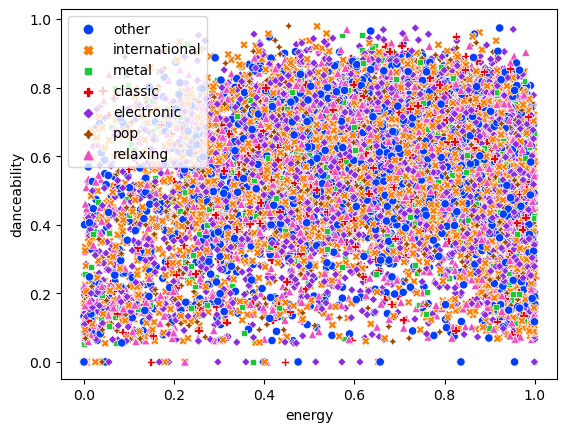

In [343]:
sns.scatterplot(data=df_km, 
                x="energy",
                y="danceability",
                hue=y,
                style=y,
                palette="bright")
plt.show()

#### Normalizzo

In [344]:
# min-max, fit and trasform directly
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

In [345]:
# z-score, fit and then transform
scaler = StandardScaler()
scaler.fit(X)
X_scal = scaler.transform(X)

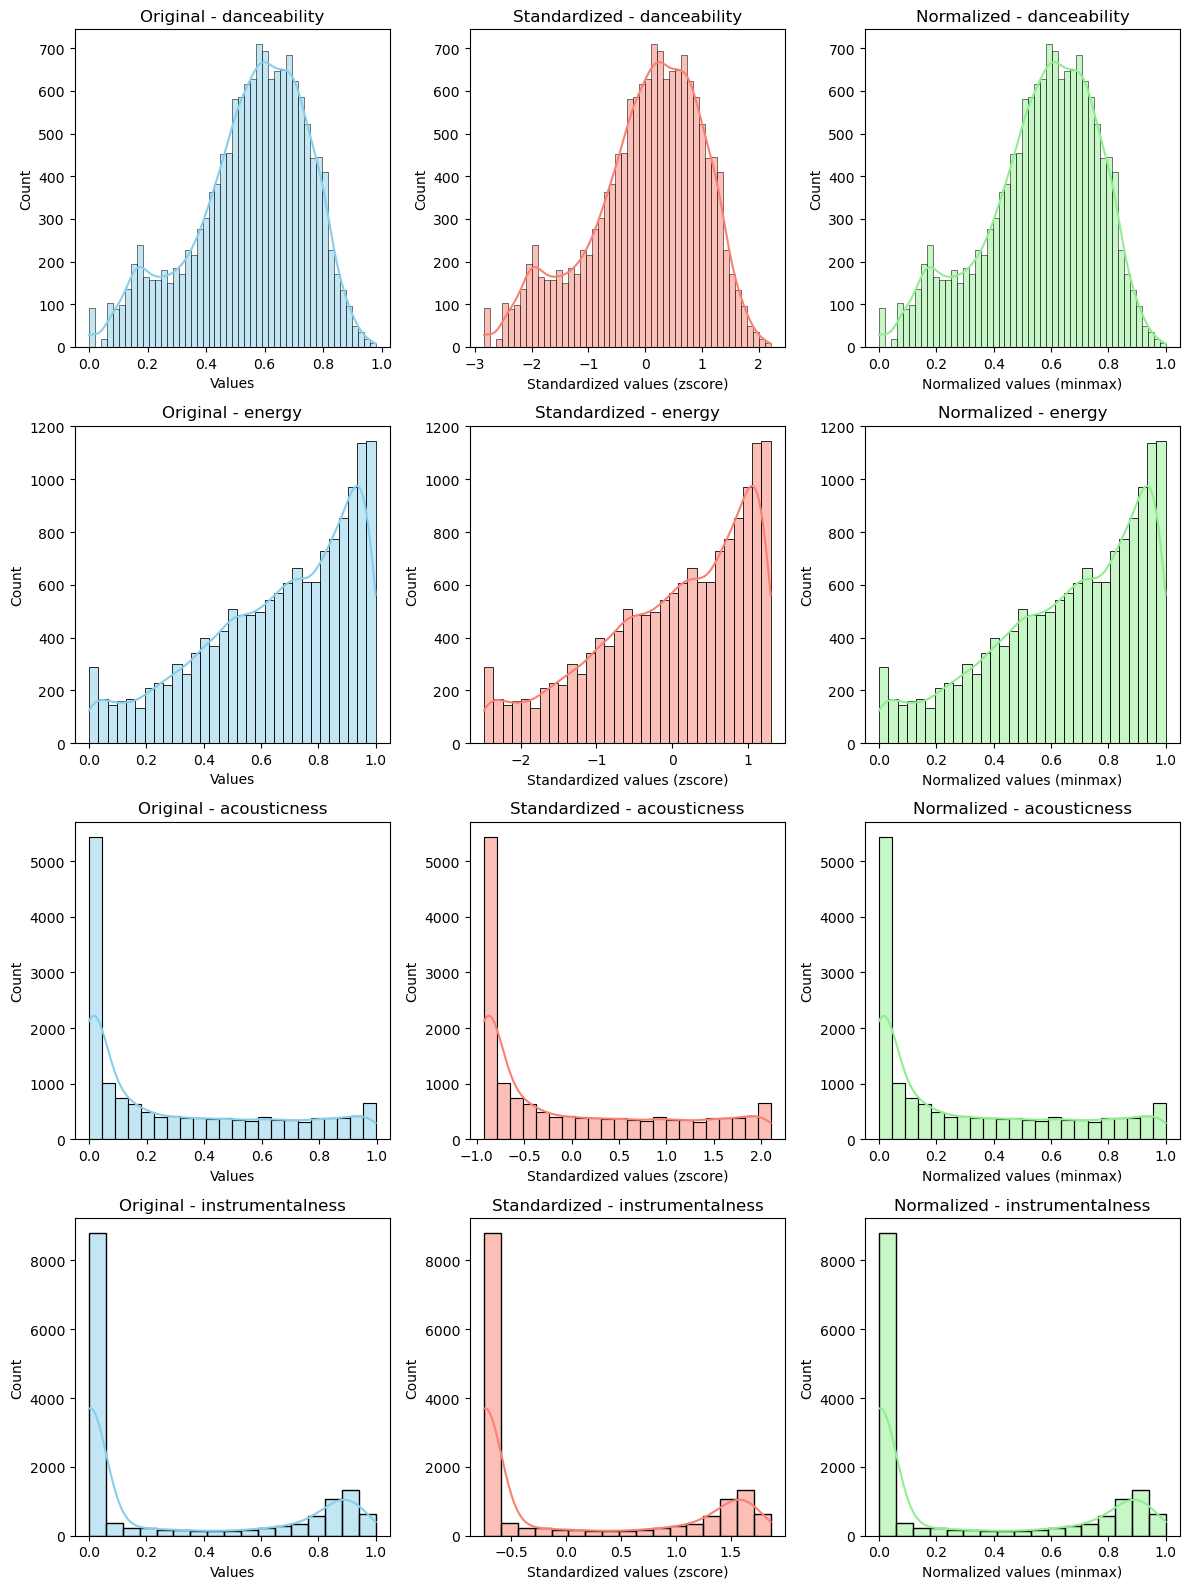

In [346]:

# Indici delle colonne che vuoi visualizzare
columns_indices = [0, 1, 2, 3]  # Sostituisci con gli indici delle tue colonne

# Creazione di un array di subplots
fig, axs = plt.subplots(len(columns_indices), 3, figsize=(12, 4 * len(columns_indices)))  # len(columns_indices) rows, 3 columns

# Iterazione su ogni indice di colonna
for j, i in enumerate(columns_indices):
    # Plot originale
    
    sns.histplot(X[:, i], ax=axs[j, 0], color='skyblue', kde=True).set(title=f'Original - {df_km.columns[i]}')
    axs[j, 0].set(xlabel='Values')

    # Plot standardizzato
    sns.histplot(X_scal[:, i], ax=axs[j, 1], color='salmon', kde=True).set(title=f'Standardized - {df_km.columns[i]}')
    axs[j, 1].set(xlabel='Standardized values (zscore)')

    # Plot normalizzato
    sns.histplot(X_minmax[:, i], ax=axs[j, 2], color='lightgreen', kde=True).set(title=f'Normalized - {df_km.columns[i]}')
    axs[j, 2].set(xlabel='Normalized values (minmax)')

plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()


#### Kmeans

In [347]:
kmeans = KMeans(n_clusters=7, n_init=10, max_iter=150, random_state=4)
kmeans.fit(X_minmax)

KMeans(max_iter=150, n_clusters=7, n_init=10, random_state=4)

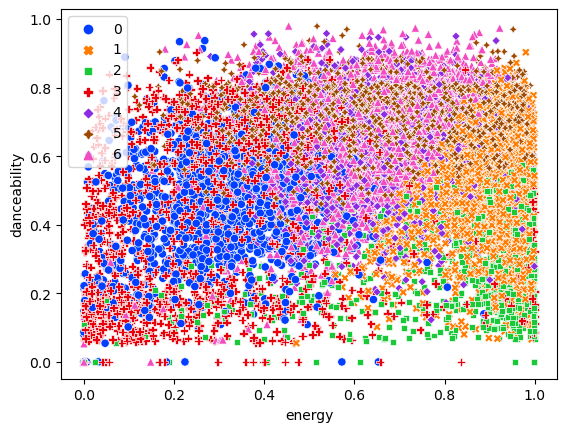

In [348]:
sns.scatterplot(data=df_km, 
                x="energy",
                y="danceability",
                hue=kmeans.labels_,
                style=kmeans.labels_,
                palette="bright")
plt.show()

In [349]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers

array([[0.64802553, 0.74249546, 0.56265319, 0.29799516],
       [0.65415612, 0.89384652, 0.32036197, 0.30411617],
       [0.61322133, 0.87738021, 0.32458528, 0.58741377],
       [0.62769374, 0.7276815 , 0.57603818, 0.61831564],
       [0.67391027, 0.83300386, 0.47192426, 0.29205737],
       [0.68979272, 0.84338652, 0.3350232 , 0.59296114],
       [0.68325031, 0.82663393, 0.342594  , 0.29667699]])

In [350]:
df_km['kmeans_labels'] = kmeans.labels_
df_km['kmeans_labels'] = df_km['kmeans_labels'].map({0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:'G'})

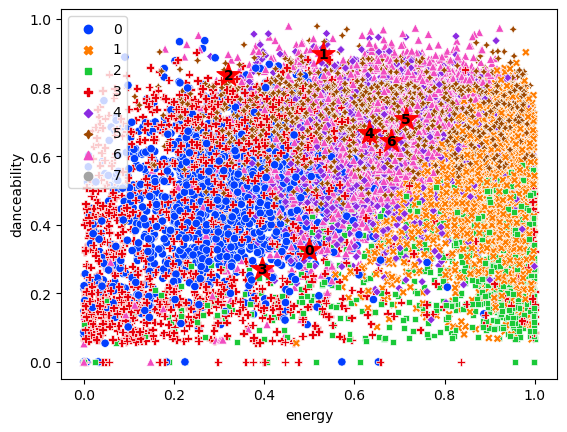

In [351]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assumendo che df_km contenga le colonne 'energy' e 'danceability' insieme ai cluster assegnati da kmeans
# e che centers contenga le coordinate dei centroidi

sns.scatterplot(data=df_km, 
                x="energy",
                y="danceability",
                hue=kmeans.labels_,
                style=kmeans.labels_,
                palette="bright", 
                hue_order=[0,1,2,3,4,5,6,7]
               )

# Aggiungi una legenda
plt.legend()

# Visualizza i centroidi
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='*', s=300, label='Centroids')

# Etichetta i centroidi con i numeri dei cluster
for i, center in enumerate(kmeans.cluster_centers_):
    plt.text(center[0], center[1], str(i), fontsize=10, ha='center', va='center', color='black', fontweight='bold')


# Mostra il grafico
plt.show()


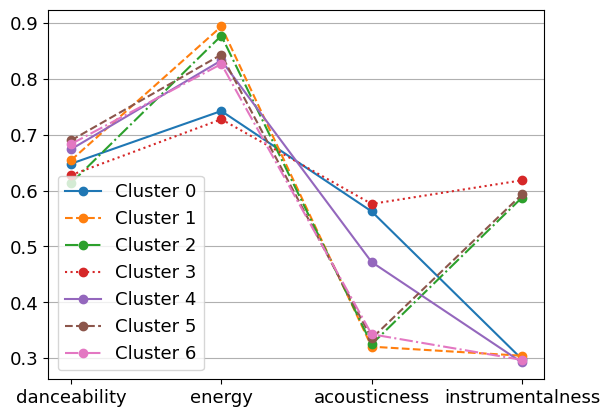

In [352]:
clust_name = [0, 1, 2, 3, 4, 5, 6, 7]  # Sostituisci con i nomi dei tuoi cluster
styles = ['-', '--', '-.', ':']  # You can customize this list with the line styles you want

for i in range(len(centers)):
    plt.plot(centers[i], marker='o', linestyle=styles[i % len(styles)], label=f'Cluster {clust_name[i]}')

plt.xticks(range(0, len(df_km.columns) - 1), df_km.columns[:-1], fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=13, loc='best')
plt.grid(axis='y')

# Imposta l'aspect ratio per migliorare la visualizzazione
plt.gca().set_aspect('auto')

plt.show()


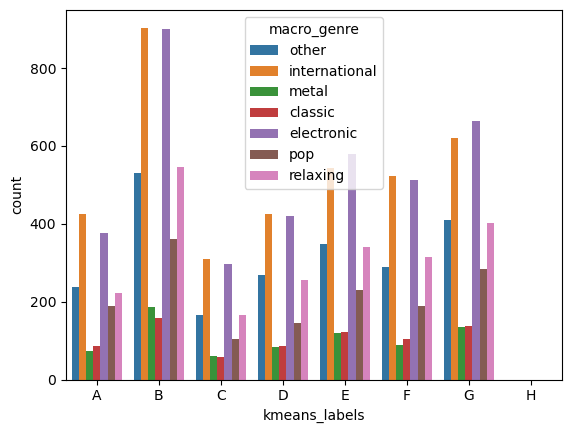

In [353]:
import seaborn as sns

# Unisci y_mapped a df_km
df_km = pd.concat([df_km, y_mapped], axis=1)

# Plotta il countplot
sns.countplot(data=df_km, x='kmeans_labels', hue='macro_genre', order=['A','B','C','D','E','F','G','H'])
plt.show()


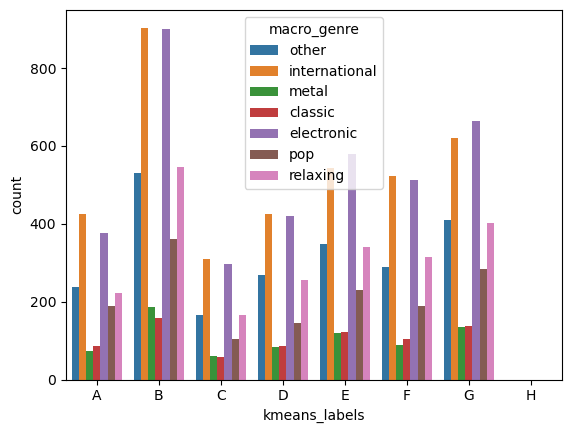

In [354]:
sns.countplot(data=df_km, x='kmeans_labels', hue=y_mapped, order=['A','B','C','D','E','F','G','H'])
plt.show()

In [355]:
y_mapped.groupby(df_km['kmeans_labels']).value_counts(normalize=True)

kmeans_labels  macro_genre  
A              international    0.263846
               electronic       0.234599
               other            0.147480
               relaxing         0.138146
               pop              0.116988
               classic          0.053516
               metal            0.045426
B              international    0.252091
               electronic       0.250976
               relaxing         0.152259
               other            0.147797
               pop              0.100669
               metal            0.052147
               classic          0.044060
C              international    0.266323
               electronic       0.255155
               other            0.143471
               relaxing         0.143471
               pop              0.089347
               metal            0.052405
               classic          0.049828
D              international    0.251926
               electronic       0.249555
               other        

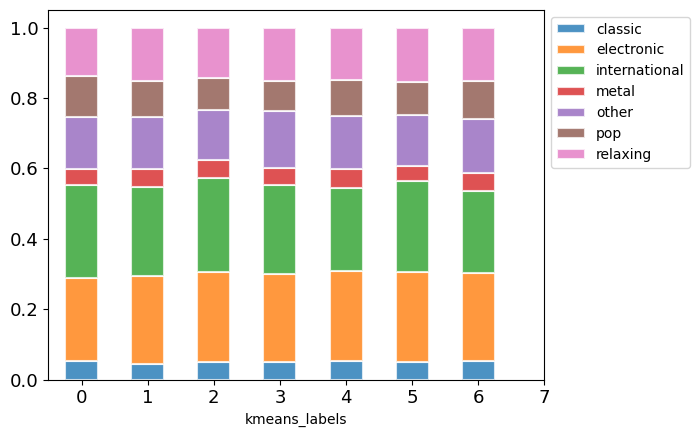

In [356]:
bar_pl = y_mapped.groupby(df_km['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)

plt.xticks(range(0, len(clust_name)), clust_name, fontsize=13, rotation=0)
plt.yticks(fontsize=13)
plt.legend(bbox_to_anchor=(1,1))

plt.show()

In [357]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([1607, 3586, 1164, 1687, 2282, 2020, 2654], dtype=int64))

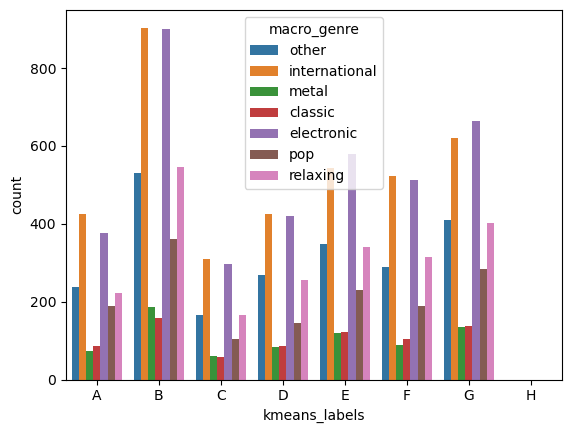

In [358]:
sns.countplot(data=df_km, x='kmeans_labels', hue=y_mapped, order=['A','B','C','D','E','F','G','H'])
plt.show()

In [367]:
# cosi non va perchè è troppo grande NON HENTRAAAHHH
print('SSE', kmeans.inertia_)
#print('Silhouette', silhouette_score(X_minmax, kmeans.labels_))'''

SSE 1114.5232062836099


In [368]:
from sklearn.utils import resample

kmeans_labels_sampled = resample(kmeans.labels_, n_samples=1000, random_state=42)
silhouette = silhouette_score(X_minmax_sampled, kmeans_labels_sampled)
print('Silhouette', silhouette)

Silhouette 0.317299205569643


In [369]:
%%time
sse_list = []

for k in range(2, 100): # per noi sarà di più date le dimensioni maggiori
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sse_list.append(kmeans.inertia_)

CPU times: total: 15min 17s
Wall time: 3min 50s


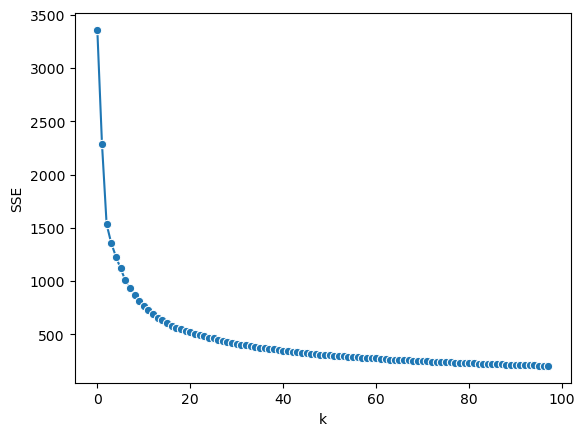

In [370]:
sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

### Bisecting kmeans

In [371]:
from sklearn.cluster import BisectingKMeans

In [421]:
bkmeans = BisectingKMeans(n_clusters=7, n_init=10, max_iter=400)
bkmeans.fit(X_minmax)

BisectingKMeans(max_iter=400, n_clusters=7, n_init=10)

In [422]:
print('Inertia:', bkmeans.inertia_)

Inertia: 1148.6080958430678


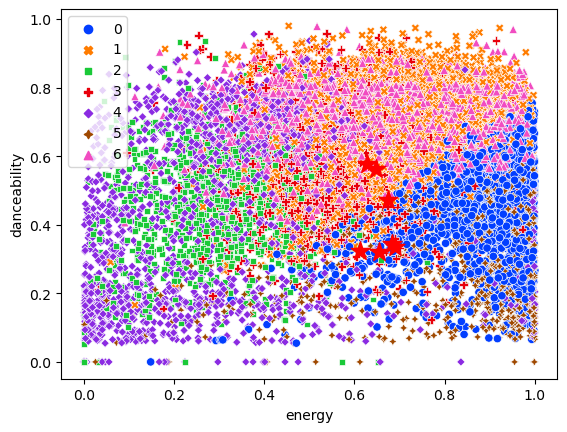

In [400]:
sns.scatterplot(data=df_km, 
                x="energy", 
                y="danceability", 
                hue=bkmeans.labels_, 
                style=bkmeans.labels_,
                palette="bright", 
               )
plt.legend()
plt.scatter(centers[:,0], centers[:,2], c='red', marker='*', s=200)
plt.show()

In [396]:
#non ce la fa da memory error
print('SSE', bkmeans.inertia_)
#print('Silhouette', silhouette_score(X_minmax, bkmeans.labels_))

SSE 1150.0936771241054
